Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [18]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [19]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [20]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))
type(words)
words[:5]
data[:5]

Data size 17005207


[5239, 3084, 12, 6, 195]

Build the dictionary and replace rare words with UNK token.

In [21]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print(dictionary.items()[:10])
print(dictionary['the'])

print(reverse_dictionary.items()[:10])
#del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
[('fawn', 45848), ('homomorphism', 9648), ('nordisk', 39343), ('nunnery', 36075), ('chthonic', 33554), ('sowell', 40562), ('sonja', 38175), ('showa', 32906), ('woods', 6263), ('hsv', 44222)]
1
[(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one'), (5, 'in'), (6, 'a'), (7, 'to'), (8, 'zero'), (9, 'nine')]


In [22]:
count = [['UNK', -1]]
count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
count

[['UNK', -1],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644),
 ('is', 183153),
 ('as', 131815),
 ('eight', 125285),
 ('for', 118445),
 ('s', 116710),
 ('five', 115789),
 ('three', 114775),
 ('was', 112807),
 ('by', 111831),
 ('that', 109510),
 ('four', 108182),
 ('six', 102145),
 ('seven', 99683),
 ('with', 95603),
 ('on', 91250),
 ('are', 76527),
 ('it', 73334),
 ('from', 72871),
 ('or', 68945),
 ('his', 62603),
 ('an', 61925),
 ('be', 61281),
 ('this', 58832),
 ('which', 54788),
 ('at', 54576),
 ('he', 53573),
 ('also', 44358),
 ('not', 44033),
 ('have', 39712),
 ('were', 39086),
 ('has', 37866),
 ('but', 35358),
 ('other', 32433),
 ('their', 31523),
 ('its', 29567),
 ('first', 28810),
 ('they', 28553),
 ('some', 28161),
 ('had', 28100),
 ('all', 26229),
 ('more', 26223),
 ('most', 25563),
 ('can', 25519),
 ('been', 25383),
 ('such', 24413),
 ('many', 2409

Function to generate a training batch for the skip-gram model.

In [23]:
print (type(data))
print (data[:100])
print (len(data))

data[1]

<type 'list'>
[5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156, 128, 742, 477, 10572, 134, 1, 27549, 2, 1, 103, 855, 3, 1, 15068, 0, 2, 1, 151, 855, 3583, 1, 195, 11, 191, 59, 5, 6, 10742, 215, 7, 1326, 105, 455, 20, 59, 2734, 363, 7, 3676, 1, 709, 2, 372, 27, 41, 37, 54, 541, 98, 12, 6, 1426, 2760, 19, 568, 687, 7106, 1, 248, 5239, 11, 1053, 28, 1, 321, 249, 45311, 2880, 793, 187, 5239, 12, 6, 201, 603, 11, 1, 1136, 20, 2623, 26, 9015, 3, 280, 32, 4154, 142, 60, 26, 6446]
17005207


3084

In [24]:
data_index = 0


def generate_batch(batch_size, num_skips, skip_window):
  global data_index  # the global index for indicating the index of used data
  assert batch_size % num_skips == 0 ## batch_size is the size of input-output pair, which should be
  assert num_skips <= 2 * skip_window # num_skips: How many times to reuse an input to generate a label.
  batch = np.ndarray(shape=(batch_size), dtype=np.int32) # input
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32) #output
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span) # sliding window
  for _ in range(span):# initialize the sliding window (fill up)
    buffer.append(data[data_index]) # data[1] = 3084
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1) # randomly choose a word from the context of target word
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:32]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'UNK', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'term', 'anarchism', 'originated', 'of', 'originated', 'term', 'as']


Train a skip-gram model.

In [25]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
num_sampled = 64 # Number of negative examples to sample.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))


graph = tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):
  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset) # train_dataset is lookup ID. and embeddings are dictionary.
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [38]:
batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
print(len(batch_data))
print(len(batch_labels))
print(batch_data)
print(batch_labels)

128
128
[ 3676  3676  3676  3676     1     1     1     1   709   709   709   709
     2     2     2     2   372   372   372   372    27    27    27    27
    41    41    41    41    37    37    37    37    54    54    54    54
   541   541   541   541    98    98    98    98    12    12    12    12
     6     6     6     6  1426  1426  1426  1426  2760  2760  2760  2760
    19    19    19    19   568   568   568   568   687   687   687   687
  7106  7106  7106  7106     1     1     1     1   248   248   248   248
  5239  5239  5239  5239    11    11    11    11  1053  1053  1053  1053
    28    28    28    28     1     1     1     1   321   321   321   321
   249   249   249   249 45311 45311 45311 45311  2880  2880  2880  2880
   793   793   793   793   187   187   187   187]
[[  363]
 [    7]
 [    1]
 [  709]
 [ 3676]
 [  709]
 [    7]
 [    2]
 [    1]
 [  372]
 [    2]
 [ 3676]
 [   27]
 [  709]
 [  372]
 [    1]
 [    2]
 [   41]
 [  709]
 [   27]
 [   41]
 [    2]
 [   37]
 [  3

In [8]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.710162
Nearest to for: multiplies, underbelly, cook, pleasurable, arterial, wagner, worldview, druze,
Nearest to zero: preventative, cpc, boyars, angiosperms, narcotic, daewoo, dreamt, charts,
Nearest to system: solanaceae, quietly, fervent, corresponded, decoys, gime, bubblegum, orchestral,
Nearest to one: speaking, naturalised, offspring, bicoid, sasson, initiates, hacker, coexistence,
Nearest to first: sliced, settlers, nikola, kurt, reinforcement, coefficient, gallica, his,
Nearest to were: dios, replies, ida, diatomaceous, affirm, monarchies, reaction, yell,
Nearest to people: ons, ancyra, prisoner, adhesive, py, popularized, narbonne, divina,
Nearest to it: khuzestan, zelda, renovated, mandriva, eudes, jackets, wars, defer,
Nearest to if: ias, visually, hydrodynamic, myth, chr, grossly, bachelors, highgate,
Nearest to the: aon, fixture, pixar, amsterdam, unemployment, illicit, traders, bering,
Nearest to during: gelling, etymological, md, car

Average loss at step 52000: 3.439144
Average loss at step 54000: 3.427009
Average loss at step 56000: 3.438108
Average loss at step 58000: 3.399076
Average loss at step 60000: 3.395372
Nearest to for: without, including, of, when, if, brushed, druze, buoyed,
Nearest to zero: five, four, eight, seven, six, nine, three, two,
Nearest to system: systems, solanaceae, semitone, branko, instantaneously, penchant, stage, thunderstorms,
Nearest to one: two, four, six, seven, eight, three, five, nine,
Nearest to first: second, next, last, same, only, final, carina, third,
Nearest to were: are, was, have, had, those, including, be, belles,
Nearest to people: those, men, children, players, scientists, letters, countries, burrito,
Nearest to it: she, he, there, this, what, which, they, itself,
Nearest to if: when, where, though, because, gammu, before, then, although,
Nearest to the: their, its, a, his, this, each, hops, some,
Nearest to during: after, in, when, throughout, following, before, under

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

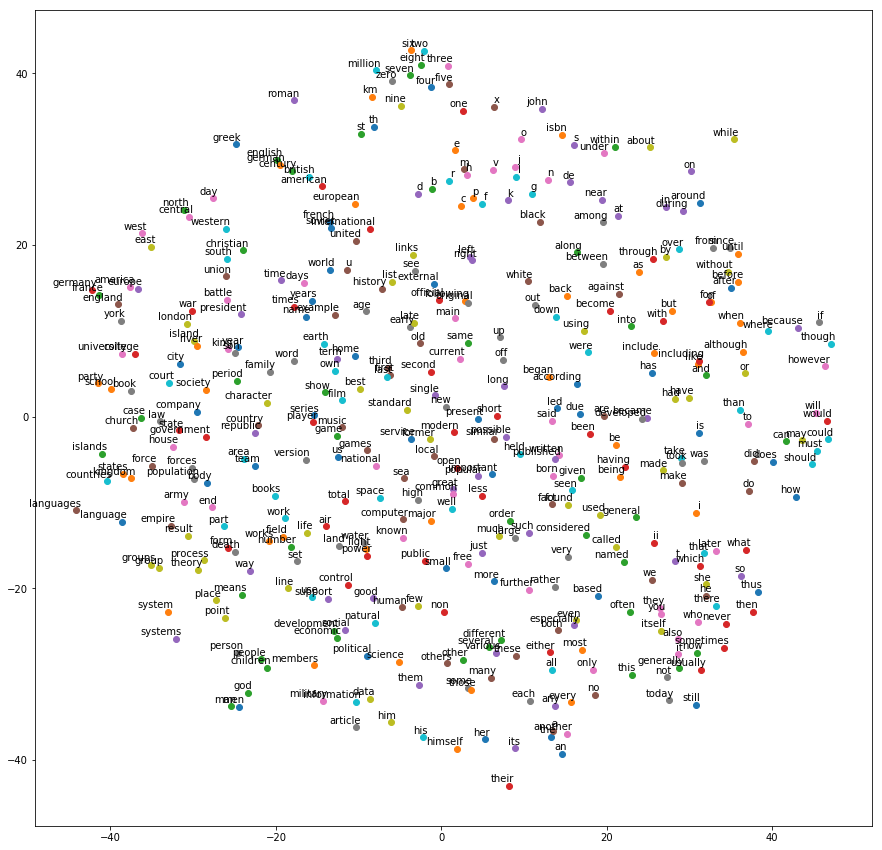

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [36]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:32]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=16, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(16)])
    


data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'UNK', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used']
    labels: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'of', 'a', 'term', 'abuse', 'of', 'first', 'used', 'abuse', 'first', 'against']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of']
    labels: ['anarchism', 'a', 'originated', 'term', 'of', 'originated', 'as', 'term', 'abuse', 'as', 'of', 'a', 'abuse', 'first', 'a', 'term']


In [33]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))

  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)

  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(
      weights = softmax_weights, biases = softmax_biases, inputs = embed, labels = train_labels,num_sampled= num_sampled, num_classes= vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [34]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 8.125724
Nearest to about: polyhedra, speciation, lightness, drang, benedetto, ste, chaldean, yaoi,
Nearest to two: eastbound, occasional, bhishma, harassed, anthropological, exterminating, marija, textbooks,
Nearest to it: pesach, conferencing, gish, elementary, kos, recites, tay, bloomsbury,
Nearest to four: lian, rosalynn, twinned, prism, bungalow, crossed, dragster, cardini,
Nearest to are: hurdle, borrowed, jabir, rusting, theosis, inward, euripides, chron,
Nearest to eight: lodge, handicrafts, backspace, suggest, kordofanian, pic, dissipate, adversaries,
Nearest to they: sm, cetaceans, preservative, alban, hogmanay, bout, festival, corinthian,
Nearest to after: penguins, gasoline, schooling, bashing, doubly, doctrine, foxe, multiprogramming,
Nearest to but: holies, lanthanum, weary, adriaan, indentations, unabridged, duty, instructor,
Nearest to he: livre, annual, amethys

Average loss at step 52000: 3.438930
Average loss at step 54000: 3.428561
Average loss at step 56000: 3.440038
Average loss at step 58000: 3.392958
Average loss at step 60000: 3.389794
Nearest to about: langston, theoretical, fetal, traveling, moody, dy, wavelength, senatus,
Nearest to two: three, four, five, one, eight, six, seven, nine,
Nearest to it: he, there, she, this, they, generally, which, what,
Nearest to four: five, six, eight, three, seven, nine, zero, two,
Nearest to are: were, is, have, include, including, although, be, schumann,
Nearest to eight: nine, six, seven, four, five, three, zero, one,
Nearest to they: we, there, you, he, she, it, not, i,
Nearest to after: before, during, when, while, without, since, into, from,
Nearest to but: however, and, although, though, see, than, pons, when,
Nearest to he: she, it, they, there, who, eventually, russell, never,
Nearest to one: eight, two, seven, four, six, nine, five, three,
Nearest to zero: five, six, four, eight, nine, se